**Homework 5:** *Data-Driven Modeling for Engineers* (ME 2063) - Instructor: H. Babaee,  **Due: 4:00 pm, February 16, 2023.**

Consider a heat conduction in a rod where the heat transfer in the rod can be accurately modeled via the one-dimensional heat conduction model given below: 
\begin{equation}
\frac{\partial T}{\partial t}= \alpha\frac{\partial^2T}{\partial x^2} + q(x)
\end{equation}
where $0 \leq x \leq 1$, $0 \leq t \leq 5$ and  $T(x,t)$ is the transient temperature and $\alpha=0.01$ is the thermal diffusivity.   The rod is subject to a distributed steady heat source according to $q(x)= 0.2\exp(-50(x-0.5)^2)$. \\


You can  download Temperature-Simulation.mat from Canvas that contains the discrete representation of $T(x,t)$ as well as discrete vectors of space and time. Hint: You can refer to Homework 5 for Python commands required to upload .mat files.  Perform PCA decomposition by computing the SVD of the temperature matrix: $[\Phi,S,V]=svd(T)$.




1.   Plot the first three spatial modes versus $x$. 
2.   Plot the singular values ($\sigma_i$'s) in semilogy axis.  
3. One criterion for reduction is to compute the percentage of ``energy" captured by the PCA reduction with $r$ modes as follows:
    \begin{equation}
       e(r)= \frac{\sum_{i=1}^r \sigma_i^2}{\sum_{i=1}^N \sigma_i^2} \times 100.        
    \end{equation}
     Use the above equation and determine the smallest rank r such that e(r)>99% , where N is the number of time snapshots. 
4. Use the PCA decomposition and reconstruct an approximate temperature matrix with $r=\{2,3,4,5\}$. Plot the error surface $E=T-Tr$ versus $x$ and $t$, where $Tr=\Phi(:,1:r)*S(1:r,1:r)*V(:,1:r)^T$ is the reconstructed matrix.
5.  Assume that we have four noisy temperature measurements at $x_M=[0.2, 0.4, 0.6, 0.8]$ for all time steps. You can download Temperature-Measurements.mat that contains measurement data for the temperature at these four points in an array named T_M. Each row of this array contains temperature measurements for a fixed location, where the four rows are measurements taken at $x=0.2, 0.4, 0.6$, and 0.8, respectively.     Consider the first three PCA modes $\Phi$ (r=3) as the basis functions. Perform regression on these basis functions using the measurement data. Plot the prediction of the regression model at $t=1,2,3$ and 4 versus x in four figures, one for each time instant. On the same figure plot the true temperature at the corresponding times. The true temperature can be extracted from matrix T at an appropriate column associated with t. Also, plot the noisy measurements on the same figure for the time instant in question. Legend accordingly. 




In [1]:
import numpy as np
import scipy.io
import scipy.interpolate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_arrays(**kwargs):
    for k, v in kwargs.items():
        print(f'{k} ∈ {v.dtype} {v.shape}')

In [2]:
# load temperature simulation

data = scipy.io.loadmat('Temperature-Simulation.mat')

T = data['T']
x = data['x'][0]
t = data['t'][0]

print_arrays(T=T, x=x, t=t)

T ∈ float64 (101, 51)
x ∈ float64 (101,)
t ∈ float64 (51,)


In [3]:
# create data frame

xx, tt = np.meshgrid(x, t, indexing='ij')

T_data = pd.DataFrame({
    'x': xx.flatten(),
    't': tt.flatten(),
    'T': T.flatten()
})
T_data

,x,t,T
0,0.0,0.0,0.001930
1,0.0,0.1,0.001930
2,0.0,0.2,0.001930
3,0.0,0.3,0.001930
4,0.0,0.4,0.001930
...,...,...,...
5146,1.0,4.6,0.003861
5147,1.0,4.7,0.003861
5148,1.0,4.8,0.003861
5149,1.0,4.9,0.003861


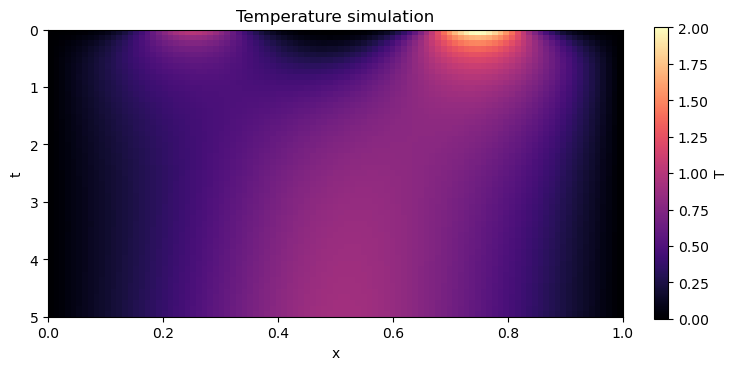

In [4]:
# plot the temperature simulation
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(T.T, cmap='magma', vmin=0, vmax=2, extent=[x[0], x[-1], t[-1], t[0]], aspect=0.1)
plt.colorbar(im, label='T', ax=ax, fraction=0.0235)
ax.set_ylabel('t')
ax.set_xlabel('x')
ax.set_title('Temperature simulation')
fig.show()

In [5]:
# singular value decomposition
U, S, V_T = np.linalg.svd(T)
print_arrays(U=U, S=S, V_T=V_T)

U ∈ float64 (101, 101)
S ∈ float64 (51,)
V_T ∈ float64 (51, 51)


In [6]:
# sanity check
r = 51
S_rect = np.zeros_like(T)
S_rect[:r,:r] = np.diag(S)
assert np.allclose(T, U @ S_rect @ V_T)

In [7]:
# spatial modes

modes = np.arange(len(x))
xx, mm = np.meshgrid(x, modes, indexing='ij')

U_data = pd.DataFrame({
    'x': xx.flatten(),
    'mode': mm.flatten(),
    'U': U.flatten()
})
U_data

,x,mode,U
0,0.0,0,-0.000341
1,0.0,1,0.000019
2,0.0,2,-0.000047
3,0.0,3,0.000122
4,0.0,4,-0.000134
...,...,...,...
10196,1.0,96,-0.068135
10197,1.0,97,-0.018635
10198,1.0,98,0.028976
10199,1.0,99,-0.065459


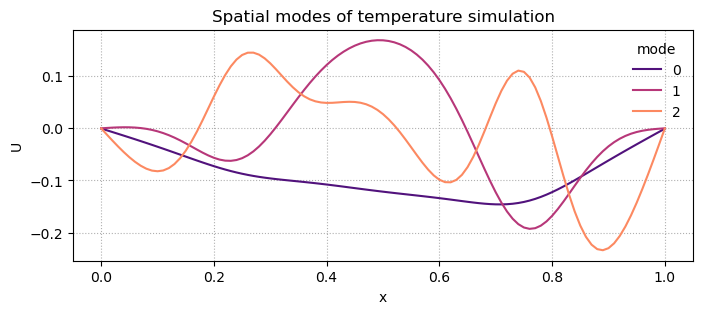

In [8]:
# plot first 3 spatial modes of temperature simulation

fig, ax = plt.subplots(figsize=(8, 3))
sns.lineplot(
    data=U_data[U_data['mode'] < 3],
    x='x', y='U', hue='mode',
    palette=sns.color_palette('magma', 3)
)
ax.set_ylabel('U')
ax.set_xlabel('x')
ax.legend(title='mode', frameon=False)
ax.set_title('Spatial modes of temperature simulation')
ax.grid(linestyle=':')

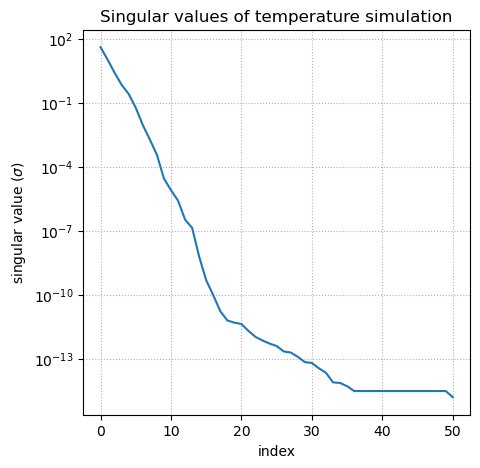

In [9]:
# plot singular values
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(S)
ax.set_yscale('log')
ax.set_ylabel('singular value ($\sigma$)')
ax.set_xlabel('index')
ax.set_title('Singular values of temperature simulation')
ax.grid(linestyle=':')

[0.93085214 0.99600488 0.99968654 0.99996027 0.99999799 0.99999995
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


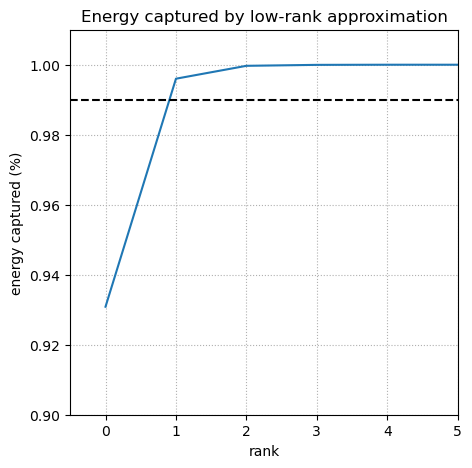

In [10]:
# plot energy captured
e = np.cumsum(S**2) / np.sum(S**2)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(e)
ax.hlines(0.99, -0.5, 5, color='k', linestyle='--')
ax.set_ylim(0.9, 1.01)
ax.set_xlim(-0.5, 5)
ax.set_ylabel('energy captured (%)')
ax.set_xlabel('rank')
ax.set_title('Energy captured by low-rank approximation')
ax.grid(linestyle=':')
print(e)

We can capture over 99% of the energy in the temperature simulation using a rank-2 SVD approximation. This means that we can approximate the simulation with over 99% accuracy using just the first two principal spatial modes.

In [11]:
# compute low rank approximations of temperature simulation

def low_rank_approx(T, r):
    U, S, V_T = np.linalg.svd(T)
    S_rect = np.zeros_like(T)
    S_rect[:r,:r] = np.diag(S[:r])
    return U[:,:r] @ S_rect[:r,:r] @ V_T[:r,:]

ranks = [2, 3, 4, 5]
T_r = [low_rank_approx(T, r) for r in ranks]

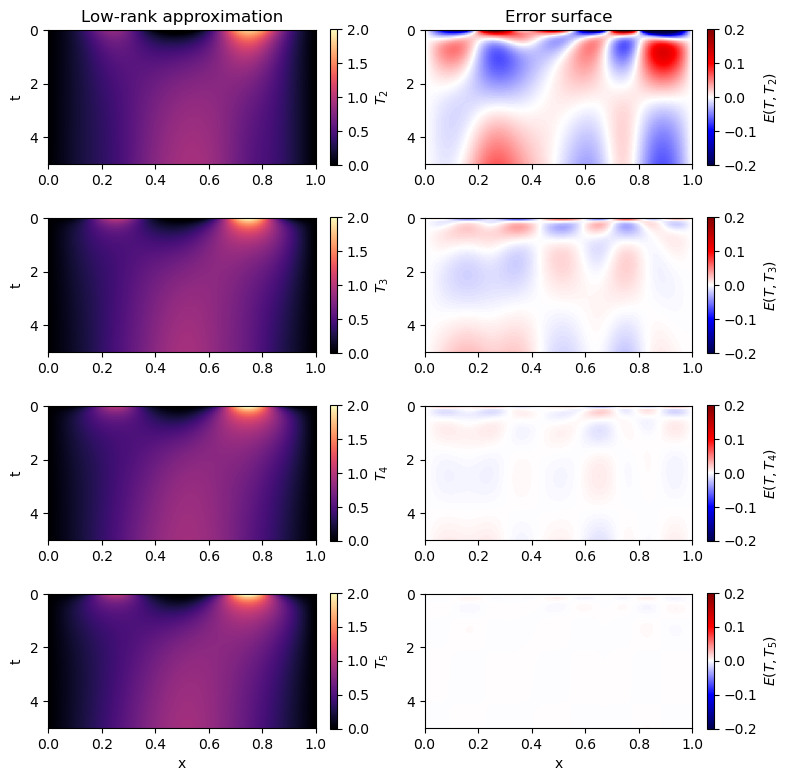

In [12]:
# plot error surface from low-rank approximation
fig, ax = plt.subplots(len(ranks), 2, figsize=(8, 2 * len(ranks)))

ax[0,0].set_title('Low-rank approximation')
ax[0,1].set_title('Error surface')

for i, r in enumerate(ranks):
    T_r = low_rank_approx(T, r)
    E = T - T_r
    
    im = ax[i,0].imshow(T_r.T, cmap='magma', vmin=0, vmax=2, extent=[x[0], x[-1], t[-1], t[0]], aspect=0.1)
    plt.colorbar(im, label=f'$T_{r}$', ax=ax[i,0], fraction=0.0235)
    
    im = ax[i,1].imshow(E.T, cmap='seismic', vmin=-0.2, vmax=0.2, extent=[x[0], x[-1], t[-1], t[0]], aspect=0.1)
    plt.colorbar(im, label=f'$E(T, T_{r})$', ax=ax[i,1], fraction=0.0235)
    
    ax[i,0].set_ylabel('t')

ax[i,0].set_xlabel('x')
ax[i,1].set_xlabel('x')

#plt.colorbar(im, label='T', ax=ax, fraction=0.0235)
fig.tight_layout()
fig.show()

In [16]:
xx.shape, tt.shape, E.shape

((101, 101), (101, 51), (101, 51))

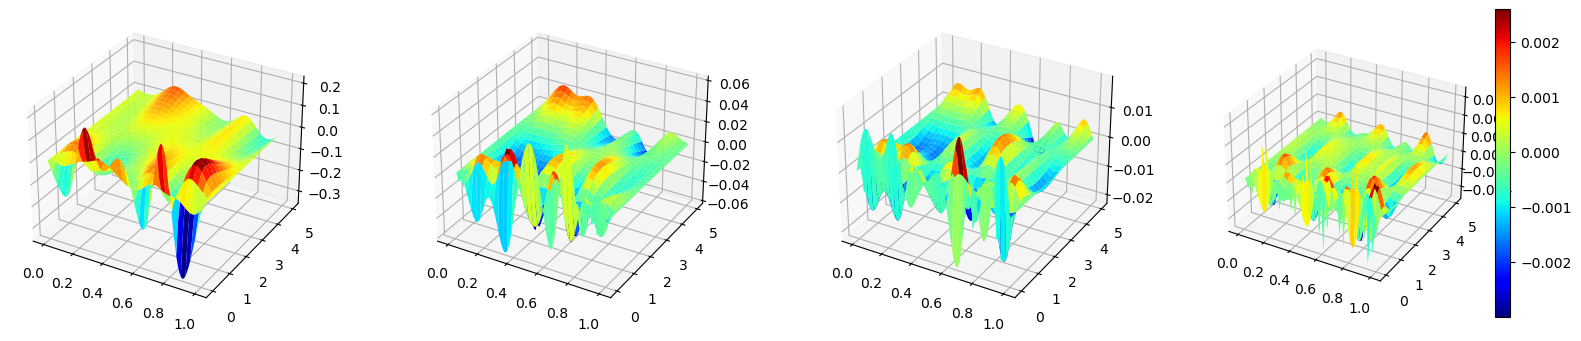

In [17]:
fig, ax = plt.subplots(1, len(ranks), figsize=(5 * len(ranks), 4), subplot_kw={'projection': '3d'})
xx, tt = np.meshgrid(x, t, indexing='ij')
t = data['t'][0]
for i, r in enumerate(ranks):
    T_r = low_rank_approx(T, r)
    E = T - T_r
    
    surf = ax[i].plot_surface(xx, tt, E, cmap='jet')
    
fig.colorbar(surf)

In [118]:
# load temperature measurements

data_M = scipy.io.loadmat('Temperature-Measurements.mat')

T_M = data_M['T_M']
x_M = data_M['x_M'][:,0]

print_arrays(T_M=T_M, x_M=x_M)

T_M ∈ float64 (4, 51)
x_M ∈ float64 (4,)


In [119]:
# regression using SVD basis functions

def linear_fit(x, y, phi):
    phi_x = phi(x)
    A = phi_x.T @ phi_x
    b = phi_x.T @ y
    return np.linalg.solve(A, b)

rank = 3
phi = scipy.interpolate.interp1d(x, U[:,:rank], axis=0)
theta = linear_fit(x_M, T_M, phi)
T_hat = phi(x) @ theta

print_arrays(T=T, T_hat=T_hat)

np.linalg.norm(T - T_hat)

T ∈ float64 (101, 51)
T_hat ∈ float64 (101, 51)


1.117554961124426

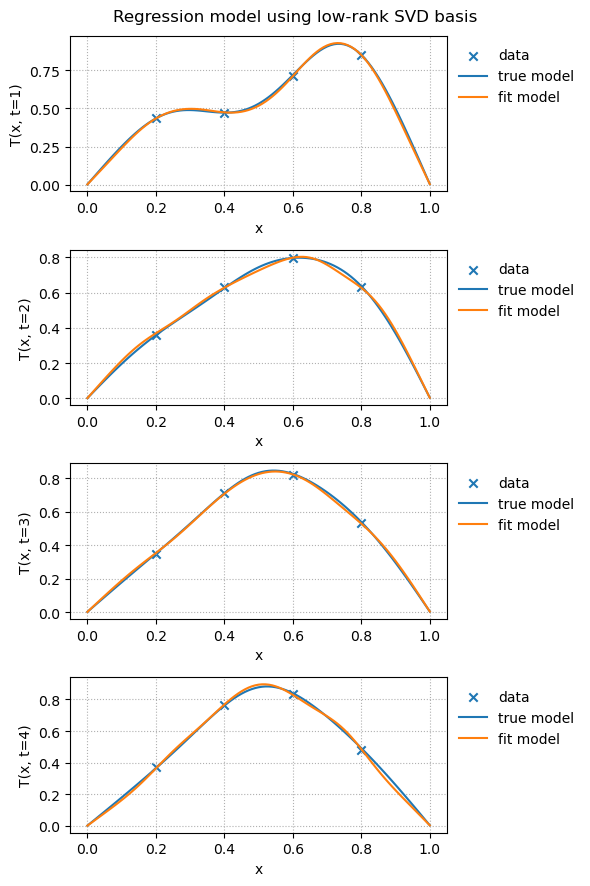

In [147]:
# plot regression model at four time instants

fig, ax = plt.subplots(4, 1, figsize=(6, 9))

for i, t_i in enumerate([1, 2, 3, 4]):
    idx = np.argmin(np.abs(t - t_i))
    ax[i].scatter(x_M, T_M[:,idx], marker='x', label='data')
    ax[i].plot(x, T[:,idx], label='true model')
    ax[i].plot(x, T_hat[:,idx], label='fit model')
    ax[i].set_ylabel(f'T(x, t={t_i})')
    ax[i].set_xlabel('x')
    ax[i].legend(frameon=False, bbox_to_anchor=(1,1))
    ax[i].grid(linestyle=':')

fig.suptitle('Regression model using low-rank SVD basis')
fig.tight_layout()